# 1. Neural Networks
This notebook has mixed types of theoretical and code implementation questions on multilayer perceptron and neural network training.

In [71]:
%run data_loader.py

Data loaded


<Figure size 640x480 with 0 Axes>

In [72]:
import math
import pickle
import gzip
import numpy as np
import pandas
from sklearn import datasets
import matplotlib.pylab as plt
import pytest
%matplotlib inline

Problem 1 - Single-Layer and Multilayer Perceptron Learning
---

**Part A** : Consider learning the following concepts with either a single-layer or multilayer perceptron where all hidden and output neurons utilize *indicator* activation functions. For each of the following concepts, state whether the concept can be learned by a single-layer perceptron. Briefly justify your response by providing weights and biases as applicable:

i. $~ \texttt{ NOT } x_1$

ii. $~~x_1 \texttt{ NOR } x_2$

iii. $~~x_1 \texttt{ XNOR } x_2$ (output 1 when $x_1 = x_2$ and 0 otherwise)

**Part B** : Determine an architecture and specific values of the weights and biases in a single-layer or multilayer perceptron with *indicator* activation functions that can learn $x_1 \texttt{ XNOR } x_2$. <br>
In this week's Peer Review, describe your architecture and state your weight matrices and bias vectors. 

Then demonstrate that your solution is correct by implementing forward propagation for your network in Python and showing that it correctly produces the correct boolean output values for each of the four possible combinations of $x_1$ and $x_2$. <br>
By reading [Neural Representation of AND, OR, NOT, XOR and XNOR Logic Gates](https://medium.com/@stanleydukor/neural-representation-of-and-or-not-xor-and-xnor-logic-gates-perceptron-algorithm-b0275375fea1)

By considering the following thruth tabel <br>
![XNOR truth tabel](https://miro.medium.com/v2/resize:fit:598/0*oGu2x1DA9soE3IdO.gif) <br>
And the following neural network <br>
![XNOR neural network](https://miro.medium.com/v2/resize:fit:640/format:webp/1*yZfw_9DRMephzZwejjhyTA.png)

In [73]:
# implement forward propagation for network
# show that it correctly produces the correct boolean output values 
# for each of the four possible combinations of x1 and x2 

def neuron(X:np.array, W:np.array, b:float):
    return activation(X@W + b)
# Initialize x with the 4 possible combinations of 0 and 1 to generate 4 values for y(output)
def activation(x):
    return 1 if x>0 else 0
def and_neuron(X:np.array):
    b = -1
    W = np.array([1,1])
    return neuron(X,W,b)
def not_neuron(X):
    W = np.array([-1])
    X = np.array([X])
    return neuron(X,W,1)
def nor_neuron(X:np.array):
    W = np.array([-1,-1])
    b = 1
    return neuron(X,W,b)
def xor_neuron(X:np.array):
    x1 = and_neuron(X)
    x2 = nor_neuron(X)
    return nor_neuron(np.array([x1,x2]))
def convert_to_array(i):
    raw = [int(j) for j in f"{i:02b}"]
    return np.array(raw)


combinations = [ convert_to_array(i) for i in range(4)]
table_format = "| {:1} | {:1} | nor({:3},{:3}) => {:3}"
header = table_format.format("a","b", "and", "nor", "xor")
print(header)
for i in combinations:
    print(table_format.format(i[0], i[1], and_neuron(i), nor_neuron(i), xor_neuron(i)))



| a | b | nor(and,nor) => xor
| 0 | 0 | nor(  0,  1) =>   0
| 0 | 1 | nor(  0,  0) =>   1
| 1 | 0 | nor(  0,  0) =>   1
| 1 | 1 | nor(  1,  0) =>   0


Problem 2 - Back propagation
---

In this problem you'll gain some intuition about why training deep neural networks can be very time consuming.  Consider training the chain-like neural network seen below: 

![chain-like nn](figs/chain_net.png)

Note that this network has three weights $W^1, W^2, W^3$ and three biases $b^1, b^2,$ and $b^3$ (for this problem you can think of each parameter as a single value or as a $1 \times 1$ matrix). Suppose that each hidden and output neuron is equipped with a sigmoid activation function and the loss function is given by 

$$
\ell(y, a^4) = \frac{1}{2}(y - a^4)^2  
$$

where $a^4$ is the value of the activation at the output neuron and $y \in \{0,1\}$ is the true label associated with the training example. 

**Part A**: Suppose each of the weights is initialized to $W^k = 1.0$ and each bias is initialized to $b^k = -0.5$.  Use forward propagation to find the activities and activations associated with each hidden and output neuron for the training example $(x, y) = (0.5,0)$. Show your work. Answer the Peer Review question about this section.

**Part B**: Use Back-Propagation to compute the weight and bias derivatives $\partial \ell / \partial W^k$ and $\partial \ell / \partial b^k$ for $k=1, 2, 3$.  Show all work. Answer the Peer Review question about this section. 

**PART C** Implement following activation functions:

Formulas for activation functions

* Relu: f($x$) = max(0, $x$)
<br><br>

* Sigmoid: f($x$) = $\frac{1}{1 + e^{-x}}$
<br><br>

* Softmax: f($x_i$) = $\frac{e^x_i}{\sum_{j=1}^{n} e^{x_j}}$

In [74]:
def relu(x):
    return max(0,x)
    

def sigmoid(x):
    return 1/(1+math.exp(-x))

def soft_max(x):
    x_exp = [math.exp(xi) for xi in x]
    den = sum(x_exp)
    return [xei/den for xei in x_exp]

In [75]:
# Activation function tests
# PLEASE NOTE: These sample tests are only indicative and are added to help you debug your code
# and there are additional hidden test cases on which your notebook will be evaluated upon submission

# Test Relu function
assert int(relu(-6.5)) == 0, "Check relu function"

# Test Sigmoid function
assert pytest.approx(sigmoid(0.3), 0.00001) == 0.574442516811659, "Check sigmoid function"

# Test Softmax function
assert pytest.approx(soft_max([5,7]), 0.00001) == [0.11920292, 0.88079708], "Check softmax function"

**PART D** Implement the following Loss functions:

Formulas for activation functions

* Mean squared error <br>
Formula: MSE = (1/n) * Σ(yi - ŷi)^2

* Mean absolute error <br>
Formula: MAE = (1/n) * Σ|yi - ŷi|

* Hinge Loss <br>
Formula: L = max(0, 1 - yi * ŷi)

In [76]:
def mean_squared_error(yhat,y):
    n = len(y)
    dif_square = [(yi-yhi)**2 for yi, yhi in zip(y,yhat)]
    return (1/n)*sum(dif_square)
    
def mean_absolute_error(yhat,y):
    n = len(y)
    dif_abs = [abs(yi-yhi) for yi, yhi in zip(y,yhat)]
    return (1/n)*sum(dif_abs)
    

def hinge(yhat,y):
    li = [max(0,1-yi*yhi) for yi, yhi in zip(y,yhat) ]
    return sum(li)/len(li)

In [77]:
# Error function tests
# PLEASE NOTE: These sample tests are only indicative and are added to help you debug your code
# and there are additional hidden test cases on which your notebook will be evaluated upon submission

y_true = np.array([2, 3, -0.45])
y_pred = np.array([1.5, 3, 0.2])

# Test mean squared error function
assert pytest.approx(mean_squared_error(y_pred,y_true), 0.00001) == 0.2241666666666667, "Check mean_squared_error function"

# Test mean absolute error function
assert pytest.approx(mean_absolute_error(y_pred,y_true), 0.00001) == 0.3833333333333333, "Check mean_absolute_error function"

# Test hinge loss function
assert pytest.approx(hinge(y_pred,y_true), 0.00001) == 0.36333333333333334, "Check hinge loss function"


Problem 3 - Build a feed-forward neural network
---

In this problem you'll implement a general feed-forward neural network class that utilizes sigmoid activation functions. Your tasks will be to implement forward propagation, prediction, back propagation, and a general train routine to learn the weights in your network via stochastic gradient descent.

The skeleton for the network class is below. Befor filling out the codes below, read the PART X instruction. The place you will complete the code is indicated as "TODO" in the code. Pleaes do not modify other parts of the code.

In [78]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
%matplotlib inline

class Network:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n, 1) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m, n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros((n, 1)) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros((n, 1)) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros((n, 1)) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros((n, 1)) for n in self.sizes]
        
    def g(self, z):
        """
        sigmoid activation function 
        
        :param z: vector of activities to apply activation to 
        """
        return 1.0 / (1.0 + np.exp(-z))
    
    def g_prime(self, z):
        """
        derivative of sigmoid activation function 
        
        :param z: vector of activities to apply derivative of activation to 
        """
        return self.g(z) * (1.0 - self.g(z))
    
    def grad_loss(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = (a-y)^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return (a - y)
    
    def forward_prop(self, x):
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        # TODO: step 1. Initialize activation on initial layer to x 
        # your code here
        self.a[0] = x
        
        ## TODO: step 2-4. Loop over layers and compute activities and activations 
        ## Use Sigmoid activation function defined above
        # your code here
        for l in range(self.L-1):
            self.z[l+1] = self.W[l]@self.a[l] + self.b[l]
            self.a[l+1] = self.g(self.z[l+1])
        
        
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        # TODO: step 1. forward prop training example to fill in activities and activations 
        # your code here
        
        
        # TODO: step 2. compute deltas on output layer (Hint: python index numbering starts from 0 ends at N-1)
        # Correction in Instructions: From the instructions mentioned below for backward propagation,
        # Use normal product instead of dot product in Step 2 and 6
        # The derivative and gradient functions have already been implemented for you
        # your code here
        
        
        # TODO: step 3-6. loop backward through layers, backprop deltas, compute dWs and dbs
        # your code here
        
            
    def train(self, X_train, y_train, X_valid=None, y_valid=None,
              eta=0.25, num_epochs=10, isPrint=True, isVis=False):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded labels 
        """
        
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        # loop over training epochs (step 1.)
        for ep in range(num_epochs):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)
            
            # loop over training examples (step 2.) 
            for ind in shuffled_inds: 
                pass
                # TODO: step 3. back prop to get derivatives 
                # your code here
                
                
                # TODO: step 4. update all weights and biases for all layers
                # your code here
                
                
            # print mean loss every 10 epochs if requested 
            if isPrint and (ep % 10) == 0:
                print("epoch {:3d}/{:3d}: ".format(ep, num_epochs), end="")
                print("  train loss: {:8.3f}".format(self.compute_loss(X_train, y_train)), end="")
                if X_valid is not None:
                    print("  validation loss: {:8.3f}".format(self.compute_loss(X_valid, y_valid)))
                else:
                    print("")
                    
            if isVis and (ep % 20) == 0:
                self.pretty_pictures(X_train, y_train, decision_boundary=True, epoch=ep)
                    
    def compute_loss(self, X, y):
        """
        compute average loss for given data set 
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        """
        loss = 0
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[np.newaxis, :]
        for x, t in zip(X, y):
            self.forward_prop(x)
            if len(t.shape) == 1:
                t = t.reshape(-1, 1)
            loss += 0.5 * np.sum((self.a[-1] - t) ** 2)
        return loss / X.shape[0]
    
    
    def gradient_check(self, x, y, h=1e-5):
        """
        check whether the gradient is correct for X, y
        
        Assuming that back_prop has finished.
        """
        for ll in range(self.L - 1):
            oldW = self.W[ll].copy()
            oldb = self.b[ll].copy()
            for i in range(self.W[ll].shape[0]):
                for j in range(self.W[ll].shape[1]):
                    self.W[ll][i, j] = oldW[i, j] + h
                    lxph = self.compute_loss(x, y)
                    self.W[ll][i, j] = oldW[i, j] - h
                    lxmh = self.compute_loss(x, y)
                    grad = (lxph - lxmh) / (2 * h)
                    assert abs(self.dW[ll][i, j] - grad) < 1e-5
                    self.W[ll][i, j] = oldW[i, j]
            for i in range(self.b[ll].shape[0]):
                j = 0
                self.b[ll][i, j] = oldb[i, j] + h
                lxph = self.compute_loss(x, y)
                self.b[ll][i, j] = oldb[i, j] - h
                lxmh = self.compute_loss(x, y)
                grad = (lxph - lxmh) / (2 * h)
                assert abs(self.db[ll][i, j] - grad) < 1e-5
                self.b[ll][i, j] = oldb[i, j]
        
            
    def pretty_pictures(self, X, y, decision_boundary=False, epoch=None):
        """
        Function to plot data and neural net decision boundary
        
        :param X: matrix of features 
        :param y: matrix of vector-encoded labels 
        :param decision_boundary: whether or not to plot decision 
        :param epoch: epoch number for printing 
        """
        
        mycolors = {"blue": "steelblue", "red": "#a76c6e"}
        colorlist = [c for (n,c) in mycolors.items()]
        colors = [colorlist[np.argmax(yk)] for yk in y]

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
        
        if decision_boundary:
            xx, yy = np.meshgrid(np.linspace(-1.25,1.25,300), np.linspace(-1.25,1.25,300))
            grid = np.column_stack((xx.ravel(), yy.ravel()))
            grid_pred = np.zeros_like(grid[:,0])
            for ii in range(len(grid_pred)):
                self.forward_prop(grid[ii,:])
                grid_pred[ii] = np.argmax(self.a[-1])
            grid_pred = grid_pred.reshape(xx.shape)
            cmap = ListedColormap([
                colorConverter.to_rgba('steelblue', alpha=0.30),
                colorConverter.to_rgba('#a76c63', alpha=0.30)])
            plt.contourf(xx, yy, grid_pred, cmap=cmap)
            if epoch is not None: plt.text(-1.23,1.15, "epoch = {:d}".format(epoch), fontsize=16)

        plt.scatter(X[:,0], X[:,1], color=colors, s=100, alpha=0.9)
        plt.axis('off')
        
def generate_data(N, config="checkerboard"):
    X = np.zeros((N,2))
    y = np.zeros((N,2)).astype(int)
    
    if config=="checkerboard":
        nps, sqlen = N//9, 2/3
        ctr = 0
        for ii in range(3):
            for jj in range(3):
                X[ctr * nps : (ctr + 1) * nps, :] = np.column_stack(
                    (np.random.uniform(ii * sqlen +.05-1, (ii+1) * sqlen - .05 -1, size=nps),
                     np.random.uniform(jj * sqlen +.05-1, (jj+1) * sqlen - .05 -1, size=nps))) 
                y[ctr*nps:(ctr+1)*nps,(3*ii+jj)%2] = 1 
                ctr += 1
                
    if config=="blobs":            
        X, yflat = datasets.make_blobs(n_samples=N, centers=[[-.5,.5],[.5,-.5]],
                                       cluster_std=[.20,.20],n_features=2)
        for kk, yk in enumerate(yflat):
            y[kk,:] = np.array([1,0]) if yk else np.array([0,1])
            
    
    if config=="circles":
        kk=0
        while kk < N / 2:
            sample = 2 * np.random.rand(2) - 1 
            if np.linalg.norm(sample) <= .45:
                X[kk,:] = sample 
                y[kk,:] = np.array([1,0])
                kk += 1 
        while kk < N:
            sample = 2 * np.random.rand(2) - 1
            dist = np.linalg.norm(sample)
            if dist < 0.9 and dist > 0.55:
                X[kk,:] = sample 
                y[kk,:] = np.array([0,1])
                kk += 1
                
    if config=="moons":
        X, yflat = datasets.make_moons(n_samples=N, noise=.05)
        X[:,0] = .5 * (X[:,0] - .5)
        X[:,1] = X[:,1] - .25
        for kk, yk in enumerate(yflat):
            y[kk, :] = np.array([1,0]) if yk else np.array([0,1])
            
    return X, y

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")        

We'll be using our network to do binary classification of two-dimensional feature vectors.  Scroll down to the **Helper Functions** and examine the function ``generate_data``. Then mess around with the following cell to look at the various data sets available.  

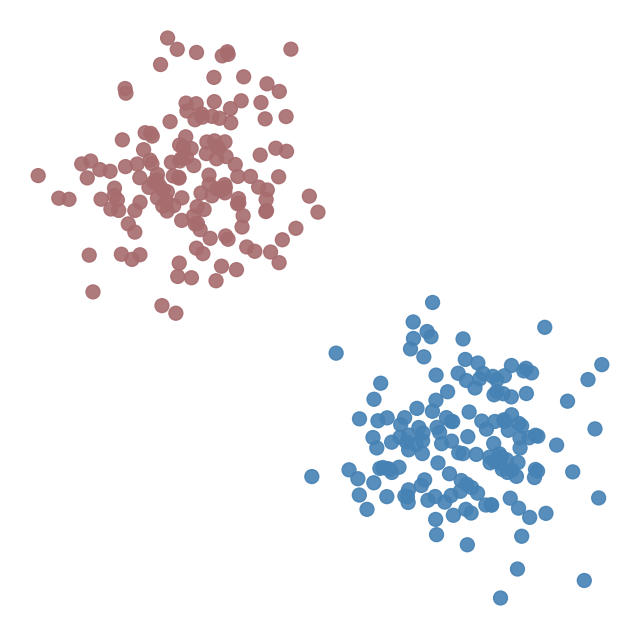

In [79]:
# play with this cell to look at the various data sets available
# your code here

nn = Network([2,3,2])
X_train, y_train = generate_data(300, "blobs")
nn.pretty_pictures(X_train, y_train, decision_boundary=False)

 Go up to the ``__init__`` function in the ``Network Class``.  How are we initializing a network?  What data structures are we using to store things like weights, biases, deltas, etc? 

**PART A.** Implementing Forward Propagation. 

Complete the ``forward_prop`` function to implement forward propagation.  Your function should take in a single training example ``x`` and propagate it forward in the network, setting the activations and activities on the hidden and output layers.  Remember that the pseudocode that we wrote for forward-prop looked as follows: 

1. $\quad$ $Initialize$ ${\bf a}^0 = {\bf x}$
2. $\quad$ $For $ $\ell = 0, \ldots, L-1$: 
3. $\quad\quad\quad$ ${\bf z}^{\ell+1} = W^\ell {\bf a}^\ell + {\bf b}^\ell$
3. $\quad\quad\quad$ ${\bf a}^{\ell+1} = g({\bf z}^{\ell+1})$

When you think you're done, we can instantiate a ``Network`` with with $2$ neurons in the input layer, $3$ neurons in the sole hidden layer, and $2$ neurons in the output layer, and then forward prop one of the training examples. 

Check that your indexing was correct by making sure that all of the activations are now non-zero (remember, we initialized them to vectors of zeros). 

What other things could we check?<br>
Answer the question about this section in this week's Peer Review assignment. 

In [81]:
# test your forward_prop function
nn = Network([2,3,2])
nn.forward_prop(X_train[0])
nn.z

[array([[0.],
        [0.]]),
 array([[ 0.12922753],
        [-2.20972463],
        [-0.10453228]]),
 array([[-0.28611315],
        [ 1.67269314]])]

**PART B.** Implementing Back Propagation

OK, now it's time to implement back propagation.  Complete the function ``back_prop`` in the ``Network`` class to use a single training example to compute the derivatives of the loss function with respect to the weights and the biases.  Remember, the pseudocode for back-prop was as follows: 

1. $\quad$ Forward propagate the training example ${\bf x}$, ${\bf y}$
2. $\quad$ Compute the  $\delta^L = \dfrac{\partial \mathscr{L}}{\partial {\bf a}^L} \odot g'({\bf z}^L)$
3. $\quad$ For $\ell = L-1, \ldots, 1$: 
4. $\quad\quad\quad \dfrac{\partial \mathscr{L}}{\partial W^\ell} = \delta^{\ell+1} ({\bf a}^\ell)^T$
5. $\quad\quad\quad \dfrac{\partial \mathscr{L}}{\partial {\bf b}^\ell} = \delta^{\ell+1}$
6. $\quad\quad\quad\delta^{\ell} = (W^\ell)^T\delta^{\ell+1} \odot g'({\bf z}^\ell)$

When you think you're done, instantiate a small ``Network`` and call back-prop for a single training example.  

Check that it's likely working by checking that the derivative matrices ``dW`` and ``db`` are nonzero. <br>
Answer the question about this section in this week's Peer Review assignment.

In [83]:
# test back_prop
nn = Network([2,3,2])
print(X_train[0,:])
nn.back_prop(X_train[0,:], y_train[0,:])
print(nn.W[0])

[ 0.45466092 -0.38109975]
[[ 0.5646463   0.90704945]
 [ 1.10017682  0.4369408 ]
 [-0.51967286  1.48574253]]


In [84]:
# test gradient_check 
nn.gradient_check(X_train[0, :], y_train[0, :])
print(nn.W[0])

AssertionError: 